# FE507 Term Project

## 1. Data Preperation

### 1.1 Getting Packages and Data 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from numpy import log as ln
import numpy as np
import math
import seaborn as sb
from scipy.stats import kstest, shapiro
import scipy.stats
import statistics
from statsmodels.graphics.tsaplots import plot_acf
    

# Set-up to have matplotlib use its support for notebook inline plotss
%matplotlib inline
pd.options.mode.chained_assignment = None 

In [4]:
df_SP500=pd.read_excel('DATA FE507 2021.xlsx',sheet_name='SP500')
df_BIST100=pd.read_excel('DATA FE507 2021.xlsx',sheet_name='BIST100')
df_BISTAll=pd.read_excel('DATA FE507 2021.xlsx',sheet_name='BIST All')
df_BTC_ETH=pd.read_excel('DATA FE507 2021.xlsx', sheet_name='Bitcoin and Ethereum')
df_Gold=pd.read_excel('DATA FE507 2021.xlsx', sheet_name='Gold')
df_TLUSD=pd.read_excel('DATA FE507 2021.xlsx',sheet_name='TL USD')
df_TRInf=pd.read_excel('DATA FE507 2021.xlsx', sheet_name='TR Inflation')
df_TRRF=pd.read_excel('DATA FE507 2021.xlsx', sheet_name='TR Deposit Rate')
#PAKAGE DEPENDENCY (pip3 install --upgrade openpyxl)

In [5]:
df_BTC_ETH

,Date,Bitcoin,Ethereum
0,2014-11-04,324.467934,NaN
1,2014-11-05,328.644408,NaN
2,2014-11-06,337.921358,NaN
3,2014-11-07,348.992860,NaN
4,2014-11-08,341.459753,NaN
...,...,...,...
2591,2021-12-08,50638.162863,4310.180119
2592,2021-12-09,50512.038512,4440.333251
2593,2021-12-10,47594.381934,4106.330000
2594,2021-12-11,47162.324050,3901.851456


In [ ]:
df_BIST100.head()

,Date,Index_V,Market_cap (m TL)
0,1988-01-04,0.07,1
1,1988-01-05,0.07,1
2,1988-01-06,0.07,1
3,1988-01-07,0.07,1
4,1988-01-08,0.07,1


In [7]:
df_BISTAll.head()

,Date,Index_V,Market_cap (m TL)
0,1997-01-02,9.94,2992
1,1997-01-03,10.30,3084
2,1997-01-06,10.50,3143
3,1997-01-07,10.87,3235
4,1997-01-08,11.32,3408


In [ ]:
df_SP500.head()

,Date,Index_V,Market_cap (m$)
0,1964-03-31,78.98,357907
1,1964-04-01,79.24,357907
2,1964-04-02,79.70,357907
3,1964-04-03,79.94,357907
4,1964-04-06,80.02,357907


### 1.2 Preparing Weekly Data

In [8]:
#define a function finding and tagging the closing days of weeks for USD based 5-Days traded time series
def week_aggregator_1(df):
    for i, row in df.iterrows():
        if i != df.shape[0]-1:
            lead=df['Date'].iloc[i+1]
            if lead!= row[0]+timedelta(days=1):
                df.at[i,'is close day'] = True
            else:
                df.at[i,'is close day'] = False
        else:
            df.at[i,'is close day'] = True
    
    df=df[(df['is close day'])]
    df['Year_ID']=df.loc[:, ('Date')].apply(lambda x: x.year)
    #I named the weeks by their Monday date
    df['Week_ID']=df.loc[:, ('Date')].apply(lambda x: x- timedelta(days=x.isoweekday()-1))
    
    del df['Date']
    del df['is close day']
    df.reset_index(inplace=True,drop=True)
    
    for i, row in df.iterrows():
        if i!=0:
            df.at[i,'Weekly Return'] = ln(row[0]/lag)
        lag=row[0]
    return df

In [9]:
df_Gold_w=df_Gold.pipe(week_aggregator_1)
df_SP500_w=df_SP500.pipe(week_aggregator_1)

In [ ]:
#define a function finding and tagging the closing days of weeks for FX based 5-Days traded time series
def week_aggregator_2(df):
    for i, row in df.iterrows():
        if i != df.shape[0]-1:
            lead=df['Date'].iloc[i+1]
            if lead!= row[0]+timedelta(days=1):
                df.at[i,'is close day'] = True
            else:
                df.at[i,'is close day'] = False
        else:
            df.at[i,'is close day'] = True
    
    df=df[(df['is close day'])]
    df['Year_ID']=df.loc[:, ('Date')].apply(lambda x: x.year)
    
    #I named the weeks by their Monday date
    df['Week_ID']=df.loc[:, ('Date')].apply(lambda x: x- timedelta(days=x.isoweekday()-1))
    
    del df['is close day']
    df.reset_index(inplace=True,drop=True)
    del df['Date']
    
    for i, row in df.iterrows():
        if i!=0:
            df.at[i,'Weekly Return in FX'] = ln(row[0]/lag_fx)
            df.at[i,'Weekly Return in USD'] =ln((row[0]/row[2])/lag_usd)
        lag_fx=row[0]
        lag_usd=row[0]/row[2]
    return df

In [ ]:
#Merge the Fx rates to the Turkish Currency DataFrames
df_BISTAll=df_BISTAll.merge(df_TLUSD, on='Date', how='left')
df_BIST100=df_BIST100.merge(df_TLUSD, on='Date', how='left')

In [ ]:
df_BISTAll_w=df_BISTAll.pipe(week_aggregator_2)
df_BIST100_w=df_BIST100.pipe(week_aggregator_2)

In [ ]:
df_BISTAll_w

,Index_V,Market_cap (m TL),TL/USD,Year_ID,Week_ID,Weekly Return in FX,Weekly Return in USD
0,10.30,3084,0.10898,1997,1996-12-30,NaN,NaN
1,11.42,3424,0.11134,1997,1997-01-06,0.103222,0.081798
2,11.87,3535,0.11355,1997,1997-01-13,0.038648,0.018993
3,14.66,4556,0.11530,1997,1997-01-20,0.211108,0.195814
4,15.63,4685,0.11615,1997,1997-01-27,0.064069,0.056724
...,...,...,...,...,...,...,...
1297,1843.32,1673481,9.98715,2021,2021-11-08,0.027449,-0.001492
1298,1943.97,1764971,11.23000,2021,2021-11-15,0.053164,-0.064126
1299,1997.75,1847589,12.38500,2021,2021-11-22,0.027289,-0.070608
1300,2140.52,1996929,13.73500,2021,2021-11-29,0.069027,-0.034434


In [ ]:
#define a function finding and tagging the closing days of weeks for USD based 7-Days traded time series (ETH/BTC)
def week_aggregator_3(df):
    df['is close day'] = (df['Date'].apply(lambda x: x.isoweekday())==7)
    
    df=df[(df['is close day'])]
    df['Year_ID']=df.loc[:, ('Date')].apply(lambda x: x.year)
    
    #I named the weeks by their Monday date
    df['Week_ID']=df.loc[:, ('Date')].apply(lambda x: x- timedelta(days=x.isoweekday()-1))
    
    del df['is close day']
    df.reset_index(inplace=True,drop=True)
    del df['Date']
    
    lag_2=''
    for i, row in df.iterrows():
        if i!=0:
            df.at[i,'BTC Weekly Return'] = ln(row[0]/lag_1)
            if not math.isnan(lag_2):
                df.at[i,'ETC Weekly Return'] = ln(row[1]/lag_2)
        lag_1=row[0]
        lag_2=row[1]
        
    return df

In [6]:
df_BTC_ETH_w=df_BTC_ETH.pipe(week_aggregator_3)

NameError: name 'week_aggregator_3' is not defined

In [ ]:
df_BTC_ETH_w

,Bitcoin,Ethereum,Year_ID,Week_ID,BTC Weekly Return,ETC Weekly Return
0,344.745289,NaN,2014,2014-11-03,NaN,NaN
1,374.983975,NaN,2014,2014-11-10,0.084077,NaN
2,352.080105,NaN,2014,2014-11-17,-0.063025,NaN
3,375.964613,NaN,2014,2014-11-24,0.065636,NaN
4,375.097528,NaN,2014,2014-12-01,-0.002309,NaN
...,...,...,...,...,...,...
366,64414.909083,4646.859294,2021,2021-11-08,0.045716,0.027196
367,59752.144235,4415.109310,2021,2021-11-15,-0.075140,-0.051159
368,54784.900000,4100.203900,2021,2021-11-22,-0.086790,-0.073996
369,49266.120000,4126.100000,2021,2021-11-29,-0.106178,0.006296


### 1.3 Prepare Monthly Data

In [ ]:
#define a function finding and tagging the cloosing days of manths for USD based 5-Days traded time series
def month_aggregator_1(df):
    for i, row in df.iterrows():
        if i != df.shape[0]-1:
            lead=df['Date'].iloc[i+1]
            if lead.month!= row[0].month:
                df.at[i,'is close day'] = True
            else:
                df.at[i,'is close day'] = False
        else:
                df.at[i,'is close day'] = False
    
    df=df[(df['is close day'])]
    df['Year_ID']=df.loc[:, ('Date')].apply(lambda x: x.year)
    
    #I named the weeks by yyyymm
    df['Month_ID']=df.loc[:, ('Date')].apply(lambda x: str(x.year)+str(x.month))
    
    del df['is close day']
    df.reset_index(inplace=True,drop=True)
    del df['Date']
    
    for i, row in df.iterrows():
        if i!=0:
            df.at[i,'Monthly Return'] = ln(row[0]/lag)
        lag=row[0]
        
    return df

In [ ]:
df_Gold_m=df_Gold.pipe(month_aggregator_1)
df_SP500_m=df_SP500.pipe(month_aggregator_1)

In [ ]:
#define a function finding and tagging the cloosing days of months for FX based 5-Days traded time series
def month_aggregator_2(df):
    for i, row in df.iterrows():
        if i != df.shape[0]-1:
            lead=df['Date'].iloc[i+1]
            if lead.month!= row[0].month:
                df.at[i,'is close day'] = True
            else:
                df.at[i,'is close day'] = False
        else:
                df.at[i,'is close day'] = False
    
    df=df[(df['is close day'])]
    df['Year_ID']=df.loc[:, ('Date')].apply(lambda x: x.year)
    
    #I named the weeks by yyyymm
    df['Month_ID']=df.loc[:, ('Date')].apply(lambda x: str(x.year)+str(x.month))
    
    del df['is close day']
    df.reset_index(inplace=True,drop=True)
    del df['Date']
    
    for i, row in df.iterrows():
        if i!=0:
            df.at[i,'Monthly Return in FX'] = ln(row[0]/lag_fx)
            df.at[i,'Monthly Return in USD'] =ln((row[0]/row[2])/lag_usd)
        lag_fx=row[0]
        lag_usd=row[0]/row[2]
    return df

In [ ]:
df_BIST100_m=df_BIST100.pipe(month_aggregator_2)
df_BISTAll_m=df_BISTAll.pipe(month_aggregator_2)

In [ ]:
df_BIST100_m.head(100)

,Index_V,Market_cap (m TL),TL/USD,Year_ID,Month_ID,Monthly Return in FX,Monthly Return in USD
0,0.09,2,0.00111,1988,19881,NaN,NaN
1,0.07,2,0.00118,1988,19882,-0.251314,-0.312469
2,0.06,2,0.00122,1988,19883,-0.154151,-0.187487
3,0.06,2,0.00126,1988,19884,0.000000,-0.032261
4,0.06,2,0.00132,1988,19885,0.000000,-0.046520
...,...,...,...,...,...,...,...
95,4.00,882,0.06090,1995,199512,0.022757,-0.080235
96,4.95,1222,0.06288,1996,19961,0.213093,0.181098
97,6.05,1445,0.06609,1996,19962,0.200671,0.150881
98,6.70,1576,0.07088,1996,19963,0.102049,0.032078


In [ ]:
#define a function finding and tagging the cloosing days of months for USD based 7-Days traded time series (ETH/BTC)
def month_aggregator_3(df):
    for i, row in df.iterrows():
        if i != df.shape[0]-1:
            lead=df['Date'].iloc[i+1]
            if lead.month!= row[0].month:
                df.at[i,'is close day'] = True
            else:
                df.at[i,'is close day'] = False
        else:
                df.at[i,'is close day'] = False
       
    df=df[(df['is close day'])]
    df['Year_ID']=df.loc[:, ('Date')].apply(lambda x: x.year)
    
    #I named the weeks by yyyymm
    df['Month_ID']=df.loc[:, ('Date')].apply(lambda x: str(x.year)+str(x.month))
    
    del df['is close day']
    df.reset_index(inplace=True,drop=True)
    del df['Date']
    
    lag_2=''
    for i, row in df.iterrows():
        if i!=0:
            df.at[i,'BTC Monthly Return'] = ln(row[0]/lag_1)
            if not math.isnan(lag_2):
                df.at[i,'ETC Monthly Return'] = ln(row[1]/lag_2)
        lag_1=row[0]
        lag_2=row[1]
        
    return df

In [ ]:
df_BTC_ETH_m=df_BTC_ETH.pipe(month_aggregator_3)

In [ ]:
df_BTC_ETH_m.head(10)

,Bitcoin,Ethereum,Year_ID,Month_ID,BTC Monthly Return,ETC Monthly Return
0,375.964613,NaN,2014,201411,NaN,NaN
1,310.527122,NaN,2014,201412,-0.191224,NaN
2,226.717513,NaN,2015,20151,-0.314566,NaN
3,254.240418,NaN,2015,20152,0.114576,NaN
4,247.403936,NaN,2015,20153,-0.027258,NaN
5,225.062381,NaN,2015,20154,-0.094645,NaN
6,232.938981,NaN,2015,20155,0.034399,NaN
7,256.736691,NaN,2015,20156,0.097274,NaN
8,288.278261,NaN,2015,20157,0.115875,NaN
9,228.973938,NaN,2015,20158,-0.230318,NaN


### 1.4 Merge to Build Master DataFrames and Clear Intermediate Dataframes

In [ ]:
print('number of rows in df_SP500: ' ,df_SP500.shape[0])
print('number of rows in df_BIST100: ' ,df_BIST100.shape[0])
print('number of rows in df_BISTAll: ' ,df_BISTAll.shape[0])
print('number of rows in df_BTC_ETH: ' ,df_BTC_ETH.shape[0])
print('number of rows in df_Gold: ' ,df_Gold.shape[0])

number of rows in df_SP500:  15054
number of rows in df_BIST100:  8855
number of rows in df_BISTAll:  6507
number of rows in df_BTC_ETH:  2596
number of rows in df_Gold:  14073


In [ ]:
print('Max date in df_SP500: ' ,df_SP500['Date'].max(), 'Min date in df_SP500: ',df_SP500['Date'].min() )
print('Max date in df_BIST100: ' ,df_BIST100['Date'].max(), 'Min date in df_BIST100: ',df_BIST100['Date'].min() )
print('Max date in df_BISTAll: ' ,df_BISTAll['Date'].max(), 'Min date in df_BISTAll: ',df_BISTAll['Date'].min() )
print('Max date in df_BTC_ETH: ' ,df_BTC_ETH['Date'].max(), 'Min date in df_BTC_ETH: ',df_BTC_ETH['Date'].min() )
print('Max date in df_Gold: ' ,df_Gold['Date'].max(), 'Min date in df_Gold: ',df_Gold['Date'].min() )

Max date in df_SP500:  2021-12-10 00:00:00 Min date in df_SP500:  1964-03-31 00:00:00
Max date in df_BIST100:  2021-12-10 00:00:00 Min date in df_BIST100:  1988-01-04 00:00:00
Max date in df_BISTAll:  2021-12-10 00:00:00 Min date in df_BISTAll:  1997-01-02 00:00:00
Max date in df_BTC_ETH:  2021-12-12 00:00:00 Min date in df_BTC_ETH:  2014-11-04 00:00:00
Max date in df_Gold:  2021-12-10 00:00:00 Min date in df_Gold:  1968-01-03 00:00:00


SP500 is the largest data set so we will merge by the referance of SP500 dataset.

### 1.4.1  Weekly Data

In [ ]:
#start by renaming and dropping colunms
df_SP500_w=df_SP500_w.rename(columns={"Index_V": "SP500 Index", "Market_cap (m$)": "SP500 Market_cap (m$)",
                          "Weekly Return":"SP500 Weekly Return"})

df_Gold_w=df_Gold_w.rename(columns={"Price ($/t oz)": "Gold Price ($/t oz)","Weekly Return":"Gold Weekly Return"})
del df_Gold_w['Year_ID']

In [ ]:
df_BTC_ETH_w=df_BTC_ETH_w.rename(columns={"Bitcoin": "Bitcoin Price","Ethereum":"Ethereum Price"})
del df_BTC_ETH_w['Year_ID']

In [ ]:
df_BIST100_w=df_BIST100_w.rename(columns={"Index_V": "BIST100 Index", "Market_cap (m TL)": "BIST100 Market_cap (m TL)",
                          "Weekly Return in FX":"BIST100 Weekly Return in FX",
                             "Weekly Return in USD":"BIST100 Weekly Return in USD"})
del df_BIST100_w['Year_ID']
df_BISTAll_w=df_BISTAll_w.rename(columns={"Index_V": "BISTALL Index", "Market_cap (m TL)": "BISTALL Market_cap (m TL)",
                          "Weekly Return in FX":"BISTALL Weekly Return in FX",
                             "Weekly Return in USD":"BISTALL Weekly Return in USD"})
del df_BISTAll_w['Year_ID']
del df_BISTAll_w['TL/USD']

In [ ]:
df_master_w=df_SP500_w.merge(df_Gold_w,on='Week_ID', how='left')

In [ ]:
df_master_w=df_master_w.merge(df_BTC_ETH_w,on='Week_ID', how='left')

In [ ]:
df_master_w=df_master_w.merge(df_BIST100_w,on='Week_ID', how='left')

In [ ]:
df_master_w=df_master_w.merge(df_BISTAll_w,on='Week_ID', how='left')

In [ ]:
df_master_w

,SP500 Index,SP500 Market_cap (m$),Year_ID,Week_ID,SP500 Weekly Return,Gold Price ($/t oz),Gold Weekly Return,Bitcoin Price,Ethereum Price,BTC Weekly Return,ETC Weekly Return,BIST100 Index,BIST100 Market_cap (m TL),TL/USD,BIST100 Weekly Return in FX,BIST100 Weekly Return in USD,BISTALL Index,BISTALL Market_cap (m TL),BISTALL Weekly Return in FX,BISTALL Weekly Return in USD
0,79.94,357907,1964,1964-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,79.85,357907,1964,1964-04-06,-0.001126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,80.55,357907,1964,1964-04-13,0.008728,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,79.75,357907,1964,1964-04-20,-0.009981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,80.17,363019,1964,1964-04-27,0.005253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3006,4682.85,39739140,2021,2021-11-08,-0.003130,1862.36,0.028258,64414.909083,4646.859294,0.045716,0.027196,1638.50,1297522.0,9.98715,0.034087,0.005145,1843.32,1673481.0,0.027449,-0.001492
3007,4697.96,39866160,2021,2021-11-15,0.003221,1859.66,-0.001451,59752.144235,4415.109310,-0.075140,-0.051159,1737.33,1375482.0,11.23000,0.058568,-0.058721,1943.97,1764971.0,0.053164,-0.064126
3008,4594.62,38990540,2021,2021-11-22,-0.022242,1799.35,-0.032968,54784.900000,4100.203900,-0.086790,-0.073996,1776.41,1430925.0,12.38500,0.022245,-0.075652,1997.75,1847589.0,0.027289,-0.070608
3009,4538.43,38520320,2021,2021-11-29,-0.012305,1774.90,-0.013681,49266.120000,4126.100000,-0.106178,0.006296,1910.41,1558092.0,13.73500,0.072723,-0.030738,2140.52,1996929.0,0.069027,-0.034434


### 1.4.2 Monthly Data

In [ ]:
#start by renaming and dropping colunms
df_SP500_m=df_SP500_m.rename(columns={"Index_V": "SP500 Index", "Market_cap (m$)": "SP500 Market_cap (m$)",
                          "Monthly Return":"SP500 Monthly Return"})

df_Gold_m=df_Gold_m.rename(columns={"Price ($/t oz)": "Gold Price ($/t oz)","Monthly Return":"Gold Monthly Return"})
del df_Gold_m['Year_ID']

In [ ]:
df_BTC_ETH_m=df_BTC_ETH_m.rename(columns={"Bitcoin": "Bitcoin Price","Ethereum":"Ethereum Price"})
del df_BTC_ETH_m['Year_ID']

In [ ]:
df_BIST100_m=df_BIST100_m.rename(columns={"Index_V": "BIST100 Index", "Market_cap (m TL)": "BIST100 Market_cap (m TL)",
                          "Monthly Return in FX":"BIST100 Monthly Return in FX",
                             "Monthly Return in USD":"BIST100 Monthly Return in USD"})
del df_BIST100_m['Year_ID']
df_BISTAll_m=df_BISTAll_m.rename(columns={"Index_V": "BISTALL Index", "Market_cap (m TL)": "BISTALL Market_cap (m TL)",
                          "Monthly Return in FX":"BISTALL Monthly Return in FX",
                             "Monthly Return in USD":"BISTALL Monthly Return in USD"})
del df_BISTAll_m['Year_ID']
del df_BISTAll_m['TL/USD']

In [ ]:
df_master_m=df_SP500_m.merge(df_Gold_m,on='Month_ID', how='left')

In [ ]:
df_master_m=df_master_m.merge(df_BTC_ETH_m,on='Month_ID', how='left')

In [ ]:
df_master_m=df_master_m.merge(df_BIST100_m,on='Month_ID', how='left')

In [ ]:
df_master_m=df_master_m.merge(df_BISTAll_m,on='Month_ID', how='left')

In [ ]:
df_master_m

,SP500 Index,SP500 Market_cap (m$),Year_ID,Month_ID,SP500 Monthly Return,Gold Price ($/t oz),Gold Monthly Return,Bitcoin Price,Ethereum Price,BTC Monthly Return,ETC Monthly Return,BIST100 Index,BIST100 Market_cap (m TL),TL/USD,BIST100 Monthly Return in FX,BIST100 Monthly Return in USD,BISTALL Index,BISTALL Market_cap (m TL),BISTALL Monthly Return in FX,BISTALL Monthly Return in USD
0,78.98,357907,1964,19643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,79.46,363019,1964,19644,0.006059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,80.37,365840,1964,19645,0.011387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,81.69,372598,1964,19646,0.016291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,83.18,378276,1964,19647,0.018075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,4395.26,37213730,2021,20217,0.022493,1823.24,0.032221,42209.900000,2464.180000,0.186216,0.130594,1392.91,1046037.0,8.42200,0.026605,0.057643,1590.86,1388744.0,0.029005,0.060043
689,4522.68,38312130,2021,20218,0.028578,1806.30,-0.009335,46992.592288,3226.619071,0.107335,0.269576,1472.07,1110546.0,8.31450,0.055274,0.068121,1675.86,1486729.0,0.052052,0.064898
690,4307.54,36538380,2021,20219,-0.048738,1760.95,-0.025427,41538.222404,2851.080000,-0.123376,-0.123737,1406.39,1065637.0,8.88425,-0.045643,-0.111923,1612.16,1450720.0,-0.038752,-0.105031
691,4605.38,39073900,2021,202110,0.066858,1776.81,0.008966,61864.893408,4322.477426,0.398339,0.416131,1522.04,1200585.0,9.61515,0.079025,-0.000035,1735.52,1575109.0,0.073732,-0.005328



## 2. Analysis

### 2.1 Graphical Analysis of BIST100 and SP500

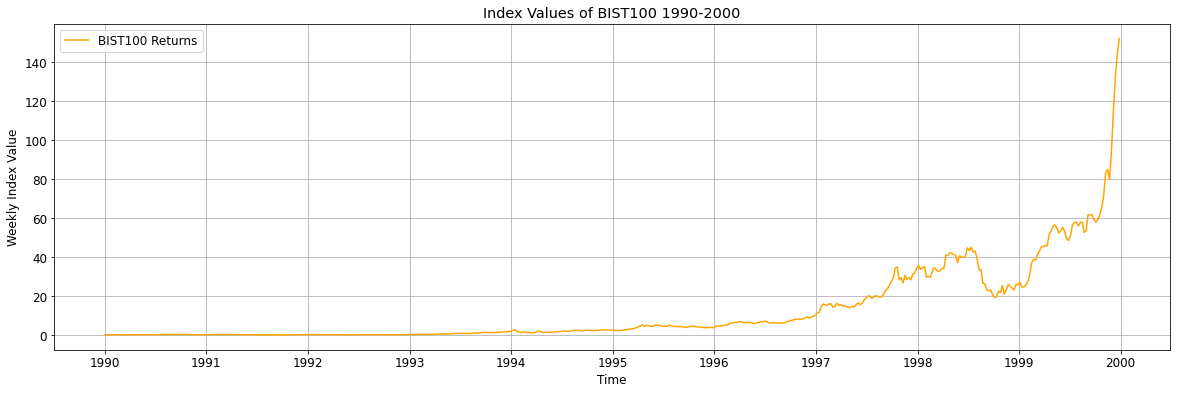

In [ ]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6))

# Specify how our lines should look
ax.plot(df_master_w[(df_master_w["Year_ID"] >=1990) & (df_master_w["Year_ID"] <=1999)]['Week_ID'], 
        df_master_w[(df_master_w["Year_ID"] >=1990) & (df_master_w["Year_ID"] <=1999)]['BIST100 Index'], 
        color='orange', label='BIST100 Returns')

ax.set_xlabel('Time')
ax.set_ylabel('Weekly Index Value')
ax.set_title('Index Values of BIST100 1990-2000')
ax.grid(True)
ax.legend(loc='upper left');

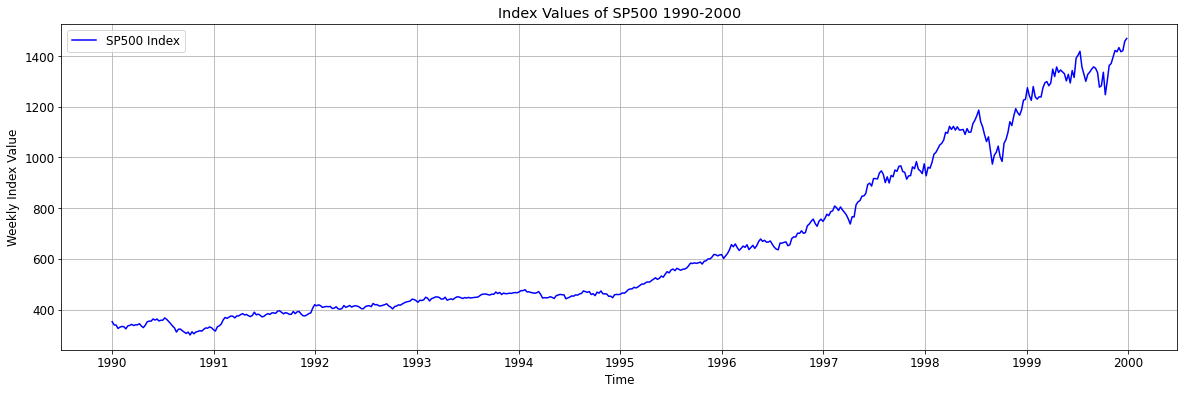

In [ ]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6))

# Specify how our lines should look
ax.plot(df_master_w[(df_master_w["Year_ID"] >=1990) & (df_master_w["Year_ID"] <=1999)]['Week_ID'], 
        df_master_w[(df_master_w["Year_ID"] >=1990) & (df_master_w["Year_ID"] <=1999)]['SP500 Index'], 
        color='blue', label='SP500 Index')

ax.set_xlabel('Time')
ax.set_ylabel('Weekly Index Value')
ax.set_title('Index Values of SP500 1990-2000')
ax.grid(True)
ax.legend(loc='upper left');


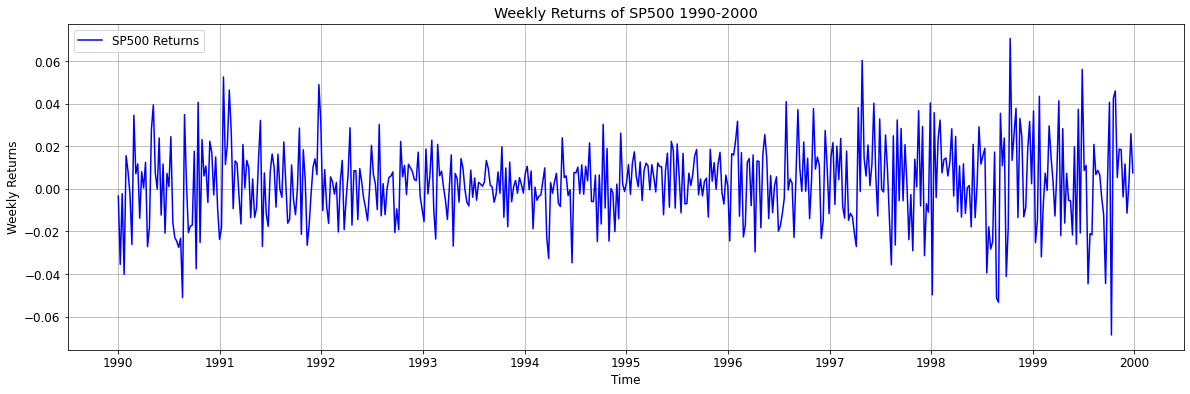

In [ ]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6))

# Specify how our lines should look
ax.plot(df_master_w[(df_master_w["Year_ID"] >=1990) & (df_master_w["Year_ID"] <=1999)]['Week_ID'], 
        df_master_w[(df_master_w["Year_ID"] >=1990) & (df_master_w["Year_ID"] <=1999)]['SP500 Weekly Return'], 
        color='blue', label='SP500 Returns')

ax.set_xlabel('Time')
ax.set_ylabel('Weekly Returns')
ax.set_title('Weekly Returns of SP500 1990-2000')
ax.grid(True)
ax.legend(loc='upper left');

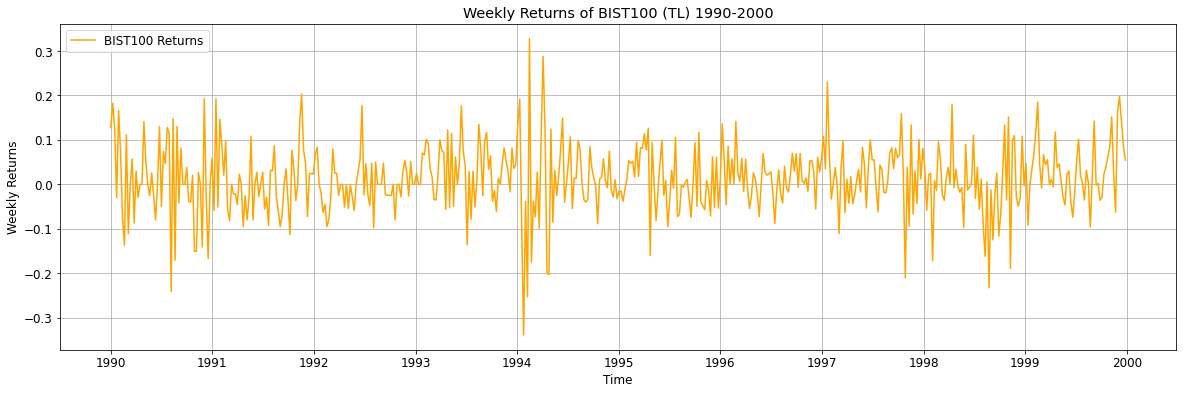

In [ ]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6))

# Specify how our lines should look
ax.plot(df_master_w[(df_master_w["Year_ID"] >=1990) & (df_master_w["Year_ID"] <=1999)]['Week_ID'], 
        df_master_w[(df_master_w["Year_ID"] >=1990) & (df_master_w["Year_ID"] <=1999)]['BIST100 Weekly Return in FX'], 
        color='orange', label='BIST100 Returns')

ax.set_xlabel('Time')
ax.set_ylabel('Weekly Returns')
ax.set_title('Weekly Returns of BIST100 (TL) 1990-2000')
ax.grid(True)
ax.legend(loc='upper left');

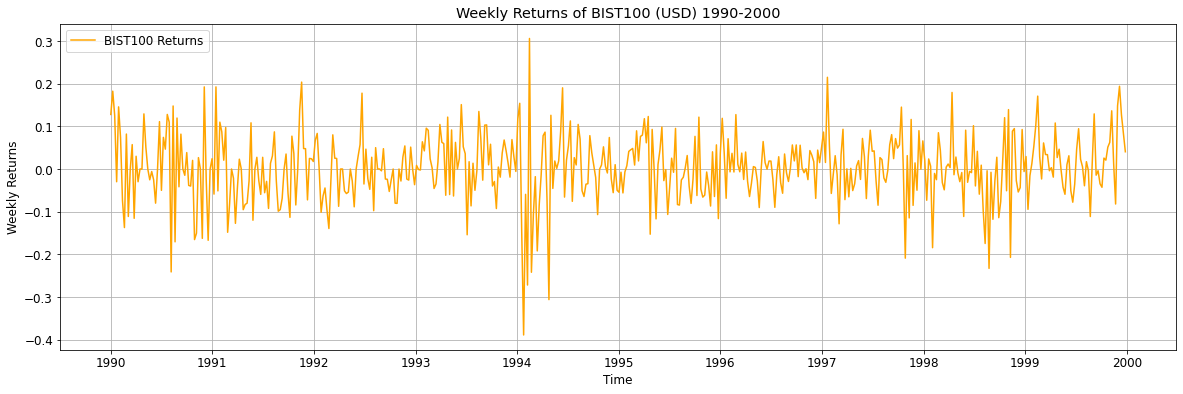

In [ ]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6))

# Specify how our lines should look
ax.plot(df_master_w[(df_master_w["Year_ID"] >=1990) & (df_master_w["Year_ID"] <=1999)]['Week_ID'], 
        df_master_w[(df_master_w["Year_ID"] >=1990) & (df_master_w["Year_ID"] <=1999)]['BIST100 Weekly Return in USD'], 
        color='orange', label='BIST100 Returns')

ax.set_xlabel('Time')
ax.set_ylabel('Weekly Returns')
ax.set_title('Weekly Returns of BIST100 (USD) 1990-2000')
ax.grid(True)
ax.legend(loc='upper left');

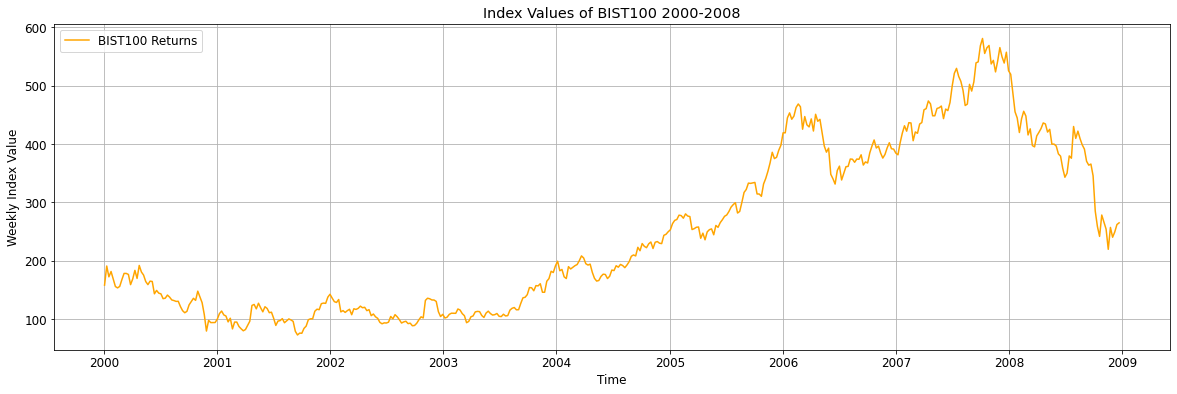

In [ ]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6))

# Specify how our lines should look
ax.plot(df_master_w[(df_master_w["Year_ID"] >=2000) & (df_master_w["Year_ID"] <=2008)]['Week_ID'], 
        df_master_w[(df_master_w["Year_ID"] >=2000) & (df_master_w["Year_ID"] <=2008)]['BIST100 Index'], 
        color='orange', label='BIST100 Returns')

ax.set_xlabel('Time')
ax.set_ylabel('Weekly Index Value')
ax.set_title('Index Values of BIST100 2000-2008')
ax.grid(True)
ax.legend(loc='upper left');

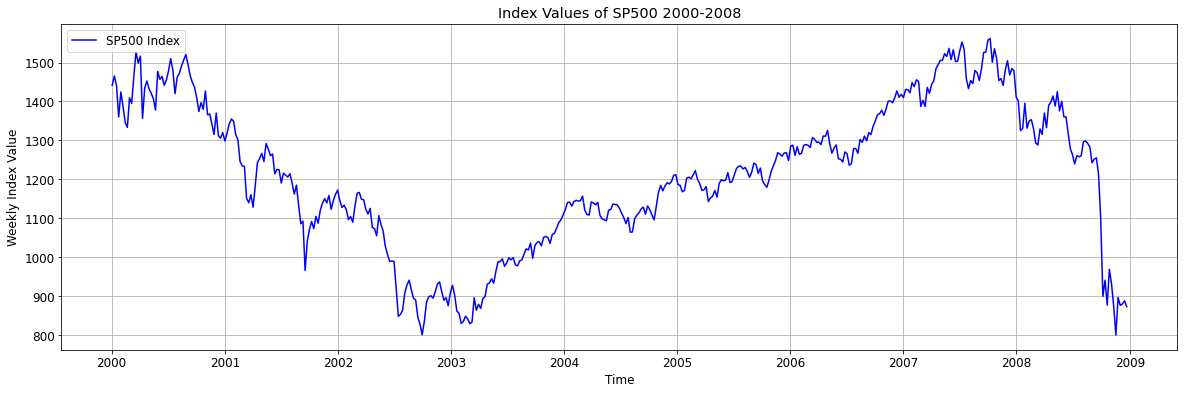

In [ ]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6))

# Specify how our lines should look
ax.plot(df_master_w[(df_master_w["Year_ID"] >=2000) & (df_master_w["Year_ID"] <=2008)]['Week_ID'], 
        df_master_w[(df_master_w["Year_ID"] >=2000) & (df_master_w["Year_ID"] <=2008)]['SP500 Index'], 
        color='blue', label='SP500 Index')

ax.set_xlabel('Time')
ax.set_ylabel('Weekly Index Value')
ax.set_title('Index Values of SP500 2000-2008')
ax.grid(True)
ax.legend(loc='upper left');


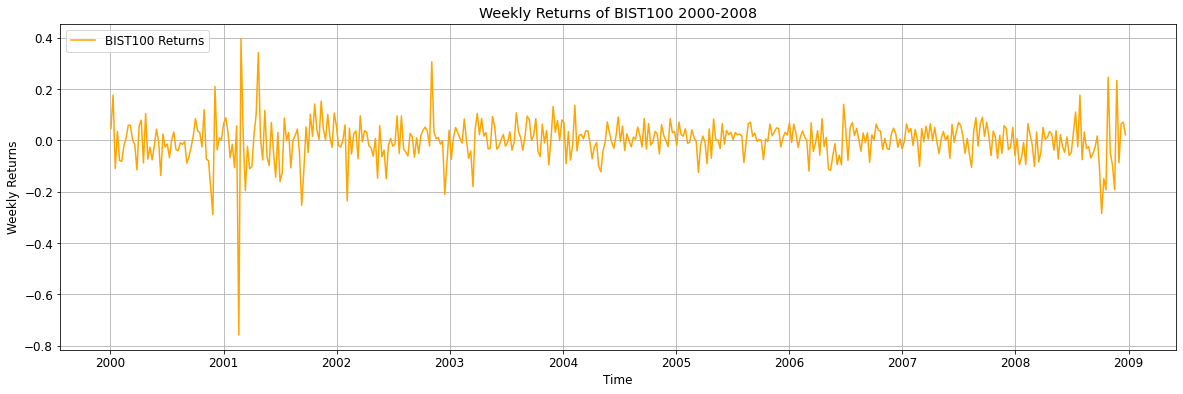

In [ ]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6))

# Specify how our lines should look
ax.plot(df_master_w[(df_master_w["Year_ID"] >=2000) & (df_master_w["Year_ID"] <=2008)]['Week_ID'], 
        df_master_w[(df_master_w["Year_ID"] >=2000) & (df_master_w["Year_ID"] <=2008)]['BIST100 Weekly Return in USD'], 
        color='orange', label='BIST100 Returns')

ax.set_xlabel('Time')
ax.set_ylabel('Weekly Returns')
ax.set_title('Weekly Returns of BIST100 2000-2008')
ax.grid(True)
ax.legend(loc='upper left');

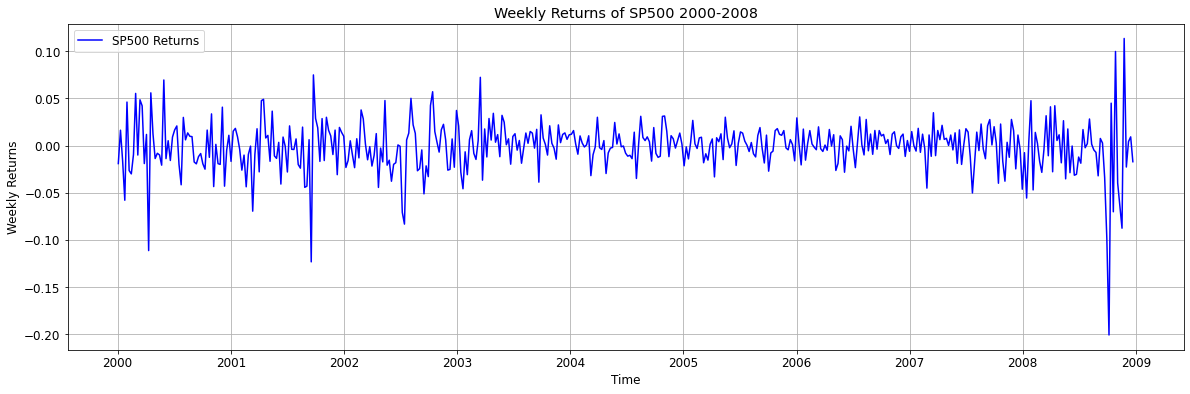

In [ ]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6))

# Specify how our lines should look
ax.plot(df_master_w[(df_master_w["Year_ID"] >=2000) & (df_master_w["Year_ID"] <=2008)]['Week_ID'], 
        df_master_w[(df_master_w["Year_ID"] >=2000) & (df_master_w["Year_ID"] <=2008)]['SP500 Weekly Return'], 
        color='blue', label='SP500 Returns')

ax.set_xlabel('Time')
ax.set_ylabel('Weekly Returns')
ax.set_title('Weekly Returns of SP500 2000-2008')
ax.grid(True)
ax.legend(loc='upper left');

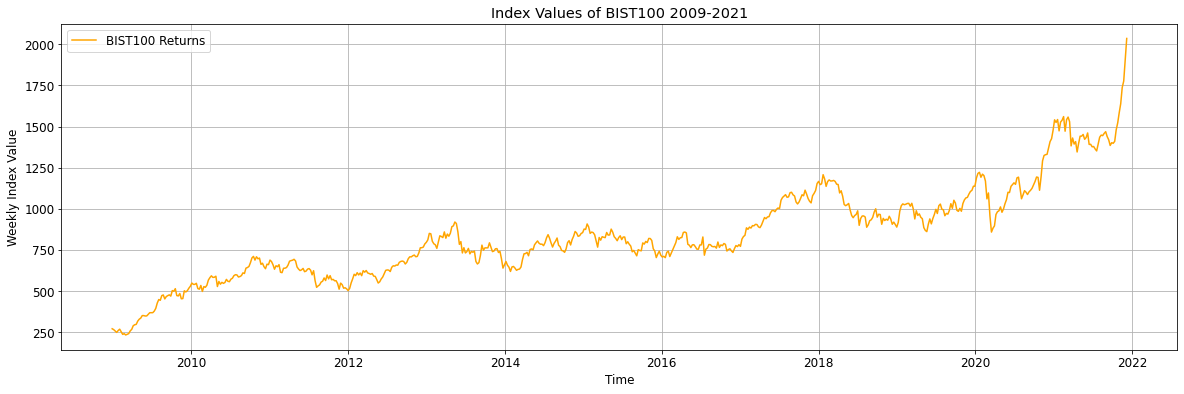

In [ ]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6))

# Specify how our lines should look
ax.plot(df_master_w[(df_master_w["Year_ID"] >=2009) & (df_master_w["Year_ID"] <=2021)]['Week_ID'], 
        df_master_w[(df_master_w["Year_ID"] >=2009) & (df_master_w["Year_ID"] <=2021)]['BIST100 Index'], 
        color='orange', label='BIST100 Returns')

ax.set_xlabel('Time')
ax.set_ylabel('Weekly Index Value')
ax.set_title('Index Values of BIST100 2009-2021')
ax.grid(True)
ax.legend(loc='upper left');

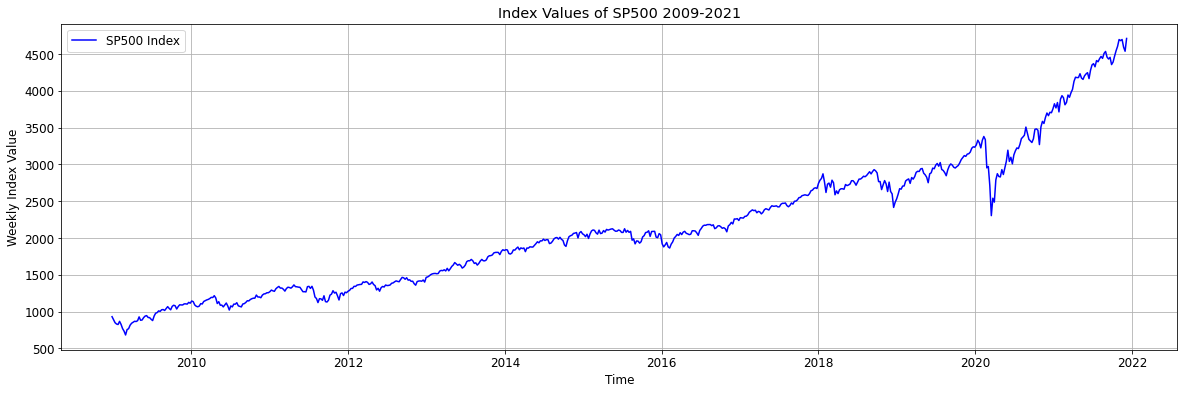

In [ ]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6))

# Specify how our lines should look
ax.plot(df_master_w[(df_master_w["Year_ID"] >=2009) & (df_master_w["Year_ID"] <=2021)]['Week_ID'], 
        df_master_w[(df_master_w["Year_ID"] >=2009) & (df_master_w["Year_ID"] <=2021)]['SP500 Index'], 
        color='blue', label='SP500 Index')

ax.set_xlabel('Time')
ax.set_ylabel('Weekly Index Value')
ax.set_title('Index Values of SP500 2009-2021')
ax.grid(True)
ax.legend(loc='upper left');


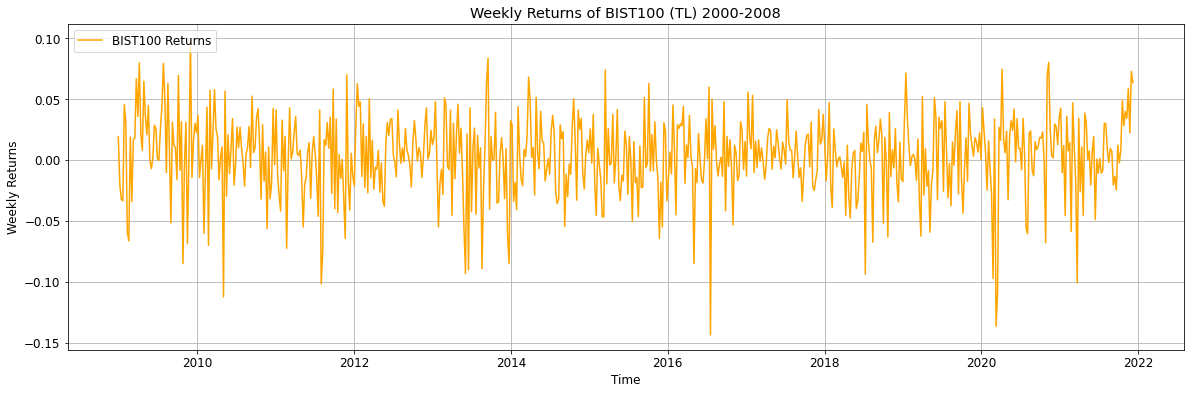

In [ ]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6))

# Specify how our lines should look
ax.plot(df_master_w[(df_master_w["Year_ID"] >=2009) & (df_master_w["Year_ID"] <=2021)]['Week_ID'], 
        df_master_w[(df_master_w["Year_ID"] >=2009) & (df_master_w["Year_ID"] <=2021)]['BIST100 Weekly Return in FX'], 
        color='orange', label='BIST100 Returns')

ax.set_xlabel('Time')
ax.set_ylabel('Weekly Returns')
ax.set_title('Weekly Returns of BIST100 (TL) 2000-2008')
ax.grid(True)
ax.legend(loc='upper left');

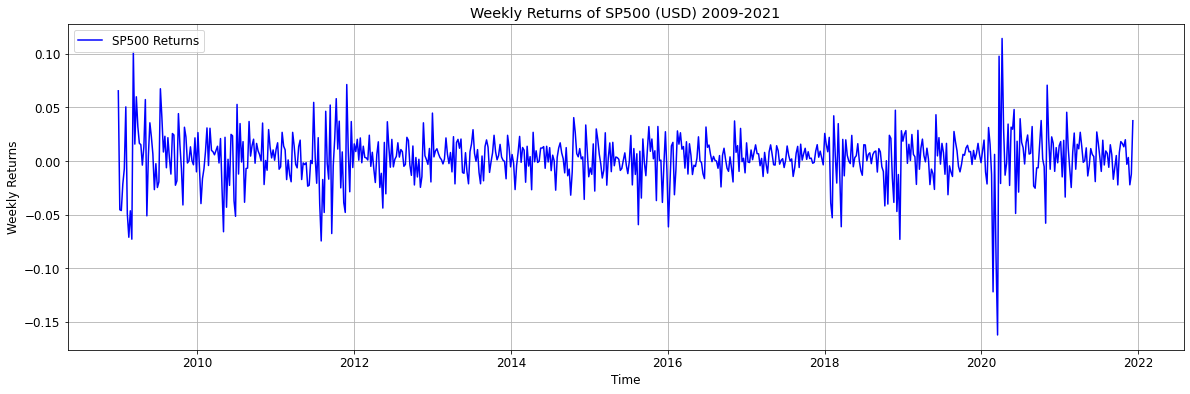

In [ ]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6))

# Specify how our lines should look
ax.plot(df_master_w[(df_master_w["Year_ID"] >=2009) & (df_master_w["Year_ID"] <=2021)]['Week_ID'], 
        df_master_w[(df_master_w["Year_ID"] >=2009) & (df_master_w["Year_ID"] <=2021)]['SP500 Weekly Return'], 
        color='blue', label='SP500 Returns')

ax.set_xlabel('Time')
ax.set_ylabel('Weekly Returns')
ax.set_title('Weekly Returns of SP500 (USD) 2009-2021')
ax.grid(True)
ax.legend(loc='upper left');

### 2.2 Statistical  Analysis of BIST100, BISTALL, Gold, BTC and SP500

In [ ]:
#Means
df_master_w[(df_master_w["Year_ID"] >=2015)][['SP500 Weekly Return','BIST100 Weekly Return in FX','BISTALL Weekly Return in FX','Gold Weekly Return',
            'BTC Weekly Return']].mean(axis = 0, skipna = False)

SP500 Weekly Return            0.002241
BIST100 Weekly Return in FX    0.002407
BISTALL Weekly Return in FX    0.002712
Gold Weekly Return             0.001109
BTC Weekly Return              0.013919
dtype: float64

In [ ]:
#Variance
df_master_w[(df_master_w["Year_ID"] >=2015)][['SP500 Weekly Return','BIST100 Weekly Return in FX','BISTALL Weekly Return in FX','Gold Weekly Return',
            'BTC Weekly Return']].var(axis = 0, skipna = False)

SP500 Weekly Return            0.000550
BIST100 Weekly Return in FX    0.001005
BISTALL Weekly Return in FX    0.000970
Gold Weekly Return             0.000388
BTC Weekly Return              0.011842
dtype: float64

In [ ]:
#Standart Deviation
df_master_w[(df_master_w["Year_ID"] >=2015)][['SP500 Weekly Return','BIST100 Weekly Return in FX','BISTALL Weekly Return in FX','Gold Weekly Return',
            'BTC Weekly Return']].std(axis = 0, skipna = False)

SP500 Weekly Return            0.023454
BIST100 Weekly Return in FX    0.031704
BISTALL Weekly Return in FX    0.031142
Gold Weekly Return             0.019687
BTC Weekly Return              0.108821
dtype: float64

In [ ]:
#Minimum
df_master_w[(df_master_w["Year_ID"] >=2015)][['SP500 Weekly Return','BIST100 Weekly Return in FX','BISTALL Weekly Return in FX','Gold Weekly Return',
            'BTC Weekly Return']].min(axis = 0, skipna = False)

SP500 Weekly Return           -0.162279
BIST100 Weekly Return in FX   -0.143709
BISTALL Weekly Return in FX   -0.153627
Gold Weekly Return            -0.085737
BTC Weekly Return             -0.543942
dtype: float64

In [ ]:
#Maximum
df_master_w[(df_master_w["Year_ID"] >=2015)][['SP500 Weekly Return','BIST100 Weekly Return in FX','BISTALL Weekly Return in FX','Gold Weekly Return',
            'BTC Weekly Return']].max(axis = 0, skipna = False)

SP500 Weekly Return            0.114237
BIST100 Weekly Return in FX    0.080043
BISTALL Weekly Return in FX    0.078798
Gold Weekly Return             0.090004
BTC Weekly Return              0.361871
dtype: float64

In [ ]:
#define function to calculate interquartile range
def find_iqr(x):
  return np.subtract(*np.percentile(x, [75, 25]))

In [ ]:
#Interquartile Range
df_master_w[(df_master_w["Year_ID"] >=2015)][['SP500 Weekly Return','BIST100 Weekly Return in FX','BISTALL Weekly Return in FX','Gold Weekly Return',
            'BTC Weekly Return']].apply(find_iqr)

SP500 Weekly Return            0.021827
BIST100 Weekly Return in FX    0.036944
BISTALL Weekly Return in FX    0.036087
Gold Weekly Return             0.023653
BTC Weekly Return              0.104727
dtype: float64

In [ ]:
#Skewness
df_master_w[(df_master_w["Year_ID"] >=2015)][['SP500 Weekly Return','BIST100 Weekly Return in FX','BISTALL Weekly Return in FX','Gold Weekly Return',
            'BTC Weekly Return']].skew()

SP500 Weekly Return           -1.324548
BIST100 Weekly Return in FX   -0.874928
BISTALL Weekly Return in FX   -1.033347
Gold Weekly Return            -0.097260
BTC Weekly Return             -0.391917
dtype: float64

In [ ]:
#Kurtosis
df_master_w[(df_master_w["Year_ID"] >=2015)][['SP500 Weekly Return','BIST100 Weekly Return in FX','BISTALL Weekly Return in FX','Gold Weekly Return',
            'BTC Weekly Return']].kurtosis()

SP500 Weekly Return            10.947682
BIST100 Weekly Return in FX     2.480672
BISTALL Weekly Return in FX     3.089286
Gold Weekly Return              2.183469
BTC Weekly Return               2.441050
dtype: float64

In [ ]:
def df_autocorr(df, lag=1, axis=0):
    """Compute full-sample column-wise autocorrelation for a DataFrame."""
    return df.apply(lambda col: col.autocorr(lag), axis=axis)

In [ ]:
#First-Order Autocorrelation
df_autocorr(df_master_w[(df_master_w["Year_ID"] >=2015)][['SP500 Weekly Return','BIST100 Weekly Return in FX','BISTALL Weekly Return in FX','Gold Weekly Return',
            'BTC Weekly Return']])

SP500 Weekly Return           -0.095930
BIST100 Weekly Return in FX   -0.008243
BISTALL Weekly Return in FX   -0.003232
Gold Weekly Return            -0.003761
BTC Weekly Return             -0.013333
dtype: float64

In [ ]:
#Covariance
df_master_w[(df_master_w["Year_ID"] >=2015)][['SP500 Weekly Return','BIST100 Weekly Return in FX','BISTALL Weekly Return in FX','Gold Weekly Return',
            'BTC Weekly Return']].cov()

,SP500 Weekly Return,BIST100 Weekly Return in FX,BISTALL Weekly Return in FX,Gold Weekly Return,BTC Weekly Return
SP500 Weekly Return,0.000550,0.000325,0.000328,0.000066,0.000359
BIST100 Weekly Return in FX,0.000325,0.001005,0.000983,0.000110,0.000467
BISTALL Weekly Return in FX,0.000328,0.000983,0.000970,0.000114,0.000502
Gold Weekly Return,0.000066,0.000110,0.000114,0.000388,0.000144
BTC Weekly Return,0.000359,0.000467,0.000502,0.000144,0.011842


In [ ]:
#Correlation
df_master_w[(df_master_w["Year_ID"] >=2015)][['SP500 Weekly Return','BIST100 Weekly Return in FX','BISTALL Weekly Return in FX','Gold Weekly Return',
            'BTC Weekly Return']].corr()

,SP500 Weekly Return,BIST100 Weekly Return in FX,BISTALL Weekly Return in FX,Gold Weekly Return,BTC Weekly Return
SP500 Weekly Return,1.000000,0.436467,0.449521,0.142453,0.140780
BIST100 Weekly Return in FX,0.436467,1.000000,0.995505,0.176752,0.135227
BISTALL Weekly Return in FX,0.449521,0.995505,1.000000,0.185621,0.147998
Gold Weekly Return,0.142453,0.176752,0.185621,1.000000,0.067437
BTC Weekly Return,0.140780,0.135227,0.147998,0.067437,1.000000


In [ ]:
#Geometric Mean
g1,g2,g3,g4,g5=1,1,1,1,1
for i, row in df_master_w[(df_master_w["Year_ID"] >=2015)][['SP500 Weekly Return','BIST100 Weekly Return in FX','BISTALL Weekly Return in FX','Gold Weekly Return',
            'BTC Weekly Return']].iterrows():
    g1*=row[0]
    g2*=row[1]
    g3*=row[2]
    g4*=row[3]
    g5*=row[4]
t=df_master_w[(df_master_w["Year_ID"] >=2015)][['SP500 Weekly Return','BIST100 Weekly Return in FX','BISTALL Weekly Return in FX','Gold Weekly Return',
            'BTC Weekly Return']].shape[0]
g1=g1**(1/t)
g2=g2**(1/t)
g3=g3**(1/t)
g4=g4**(1/t)
g5=g5**(1/t)
print('Geometric Mean of SP500 Weekly Return = ' ,g1)
print('Geometric Mean of BIST100 Weekly Return  in TL= ' ,g2)
print('Geometric Mean of BISTALL Weekly Return  in TL= ' ,g3)
print('Geometric Mean of Gold Weekly Return = ' ,g4)
print('Geometric Mean of BTC Weekly Return 	 =' ,g5)       

Geometric Mean of SP500 Weekly Return =  0.0
Geometric Mean of BIST100 Weekly Return  in TL=  0.0
Geometric Mean of BISTALL Weekly Return  in TL=  0.0
Geometric Mean of Gold Weekly Return =  0.0
Geometric Mean of BTC Weekly Return 	 = 0.0


In [ ]:
t=df_master_w[(df_master_w["Year_ID"] >=2015)][['SP500 Weekly Return','BIST100 Weekly Return in FX','BISTALL Weekly Return in FX','Gold Weekly Return',
            'BTC Weekly Return']].shape[0]
g1=g1**(1/t)
g2=g2**(1/t)
g3=g3**(1/t)
g4=g4**(1/t)
g5=g5**(1/t)
print('Geometric Mean of SP500 Weekly Return = %.3f' ,g1)
print('Geometric Mean of BIST100 Weekly Return  in TL= %.3f' ,g2)
print('Geometric Mean of BISTALL Weekly Return  in TL= %.3f' ,g3)
print('Geometric Mean of Gold Weekly Return = %.3f' ,g4)
print('Geometric Mean of BTC Weekly Return 	 %.3f=' ,g5)  

363

### 2.3.a  Moving Sample Analysis of BIST100

In [ ]:
#define a function finding Moving Avarages for 52 rolling Period
def MA52_finder_w(df):
    for i, row in df.iterrows():
        if i >52:
            total=0
            total_dif=0
            for j in range(1,53):
                total+=df['BIST100 Weekly Return in FX'].iloc[i-j]
            df.at[i,'MA52'] = total/52
            
            for j in range(1,53):
                total_dif+=(total/52-df['BIST100 Weekly Return in FX'].iloc[i-j])**2
            df.at[i,'Sigma_MA52']=(total_dif/52)**(1/2)
            
    return df

In [ ]:
df_BIST100_w_MA52=df_master_w[(df_master_w["Year_ID"] >=1990)][['Year_ID','Week_ID','BIST100 Weekly Return in FX']]
df_BIST100_w_MA52.reset_index(inplace=True,drop=True)

In [ ]:
df_BIST100_w_MA52=df_BIST100_w_MA52.pipe(MA52_finder_w)

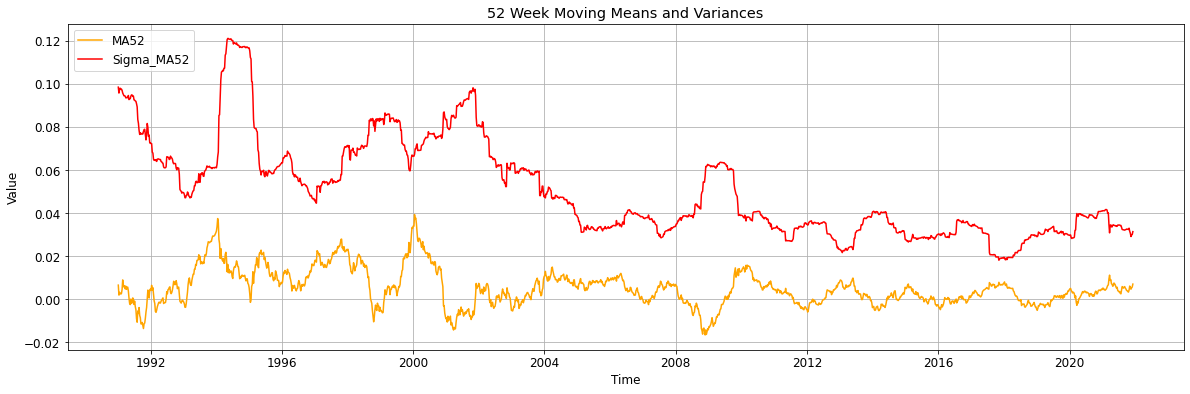

In [ ]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6))

# Specify how our lines should look
ax.plot(df_BIST100_w_MA52[(df_BIST100_w_MA52["Year_ID"] >=1990)]['Week_ID'], 
        df_BIST100_w_MA52[(df_BIST100_w_MA52["Year_ID"] >=1990)]['MA52'], 
        color='orange', label='MA52')
ax.plot(df_BIST100_w_MA52[(df_BIST100_w_MA52["Year_ID"] >=1990)]['Week_ID'], 
        df_BIST100_w_MA52[(df_BIST100_w_MA52["Year_ID"] >=1990)]['Sigma_MA52'], 
        color='red', label='Sigma_MA52')

ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title('52 Week Moving Means and Variances of BIST100 for 1990-2021')
ax.grid(True)
ax.legend(loc='upper left');
plt.show()
plt.show()

### 2.3.b Empirical Distribution of Daily and Monthly Returns for 2001-2021

In [ ]:
np_BIST100=np.array([])
df_BIST100_q3=df_BIST100[(df_BIST100["Date"].apply(lambda x: x.year) >=2000)]
df_BIST100_q3.reset_index(inplace=True,drop=True)
for i, row in df_BIST100_q3.iterrows():
    if i ==0:
        lag=row[1]
    else:
        np_BIST100=np.append(np_BIST100, [ln(row[1]/lag)])
        lag=row[1]

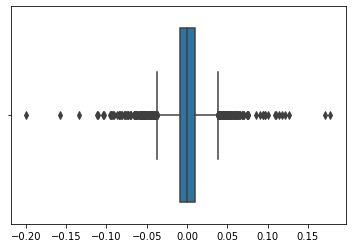

In [ ]:
ax=sb.boxplot(x=np_BIST100)

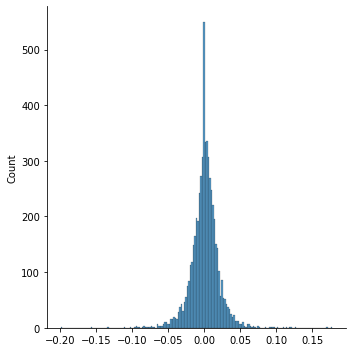

In [ ]:
bx=sb.displot(data=np_BIST100)

In [ ]:
statistic,pvalue=kstest(np_BIST100,'norm')
print('Staistic=%.3f, Pvalue= %.3f \n' %(statistic,pvalue))
if pvalue>0.05:
    print('Gausian with confidance interval 95%')
else:
    print('Not Gausian with confidance interval 95%')

Staistic=0.469, Pvalue= 0.000 

Not Gausian with confidance interval 95%


In [ ]:
df_BIST100_m

,BIST100 Index,BIST100 Market_cap (m TL),TL/USD,Month_ID,BIST100 Monthly Return in FX,BIST100 Monthly Return in USD
0,0.09,2,0.00111,19881,NaN,NaN
1,0.07,2,0.00118,19882,-0.251314,-0.312469
2,0.06,2,0.00122,19883,-0.154151,-0.187487
3,0.06,2,0.00126,19884,0.000000,-0.032261
4,0.06,2,0.00132,19885,0.000000,-0.046520
...,...,...,...,...,...,...
402,1392.91,1046037,8.42200,20217,0.026605,0.057643
403,1472.07,1110546,8.31450,20218,0.055274,0.068121
404,1406.39,1065637,8.88425,20219,-0.045643,-0.111923
405,1522.04,1200585,9.61515,202110,0.079025,-0.000035


In [ ]:
df_ara=df_BIST100_m[(df_BIST100_m["BIST100 Monthly Return in FX"].apply(lambda x: math.isnan(x)) == False)][['BIST100 Monthly Return in FX','Month_ID']]

In [ ]:
np_BIST100_m=df_ara[(df_ara["Month_ID"].apply(lambda x: int(x[:4])) >= 1990)][['BIST100 Monthly Return in FX']].to_numpy()

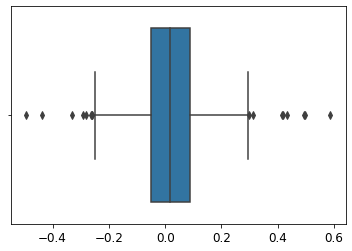

In [ ]:
ax=sb.boxplot(x=np_BIST100_m)

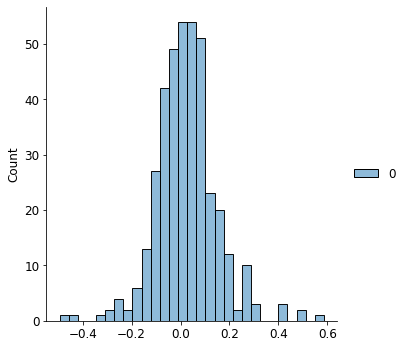

In [ ]:
bx=sb.displot(data=np_BIST100_m)

In [ ]:
statistic_m,pvalue_m=kstest(np_BIST100_m,'norm')
print('Staistic=%.3f, Pvalue= %.3f \n' %(statistic_m,pvalue_m))
if pvalue_m>0.05:
    print('Gausian with confidance interval 95%')
else:
    print('Not Gausian with confidance interval 95%')

Staistic=0.721, Pvalue= 0.000 

Not Gausian with confidance interval 95%


In [ ]:
#Skewness
df_ara['BIST100 Monthly Return in FX'].skew()

0.39116095303093157

### Autocorrelation Tests

In [ ]:
def daily_ror(df):

    df_name=[x for x in globals() if globals()[x] is df][0]
    df_name.split("_",1)[1]
    
    daily_ror = ["None"]
    daily_ror_square = ["None"]

    for i in range(len(df) - 1):
        daily_ror.append(ln(df.iloc[i + 1]["Index_V"])/ df.iloc[i]["Index_V"])
        daily_ror_square.append((ln(df.iloc[i + 1]["Index_V"])/ df.iloc[i]["Index_V"])**2)

    df['Daily_ROR'] = daily_ror
    df['Daily_ROR_square'] = daily_ror_square

    # get the year

    year = []
    for i in range(len(df)):
        year.append(df["Date"][i].year)
    df["Year"]=year

    #get the subset of dataset with respect to year

    df_from=df[df["Year"]>=2018]

    plot_acf_ror = plot_acf(x=df_from["Daily_ROR"].values, lags=30,title="R Autocorrelation "+df_name.split("_",1)[1])
    plot_acf_ror_square = plot_acf(x=df_from["Daily_ROR_square"].values, lags=30,title="R Autocorrelation Square "+df_name.split("_",1)[1])


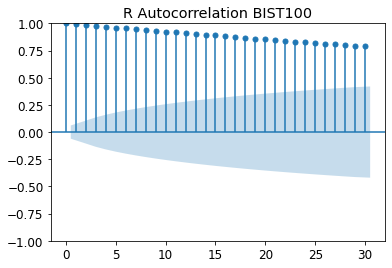

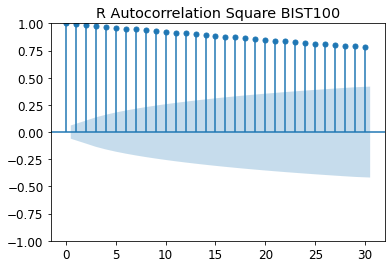

In [ ]:
daily_ror(df_BIST100)

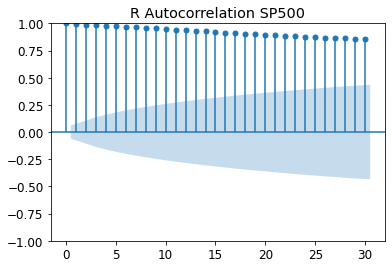

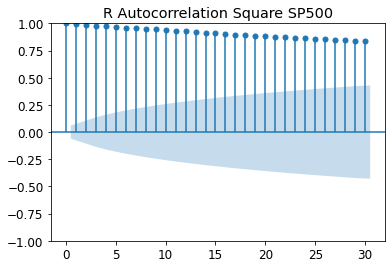

In [ ]:
daily_ror(df_SP500)

### Normality Test

In [ ]:
def probabilities(df):
    
    daily_return = ["None"]

    for i in range(len(df) - 1):
        daily_return.append(((df.iloc[i + 1]["Index_V"])-df.iloc[i]["Index_V"])/ df.iloc[i]["Index_V"])
        
    df['Daily_Return'] = daily_return

    year = []
    for i in range(len(df)):
        year.append(df["Date"][i].year)
    df["Year"]=year
    
    df_from = df[df["Year"]>=2001]
    number_of_times_event_occurs = len(df_from[df_from["Daily_Return"]<=-0.085])
    total_number_of_trials = len(df_from)

    print("Empirical probability is: " + str(number_of_times_event_occurs/total_number_of_trials))
    
    # Normal probability
    
    print("Normal probability is: " + str(scipy.stats.norm(sum(df_from["Daily_Return"])/len(df_from["Daily_Return"]), statistics.stdev(df_from["Daily_Return"])).pdf(-0.085)))

In [ ]:
probabilities(df_BIST100)

Empirical probability is: 0.0018298261665141812
Normal probability is: 0.0005850425588465742


### Value Calculations

### Risk Premiums

In [ ]:
df_TRRF.head()

,Quarter,Deposit rate,Year_ID
0,Q4 1978,6.00,1978
1,Q1 1979,6.00,1979
2,Q2 1979,7.33,1979
3,Q3 1979,8.00,1979
4,Q4 1979,8.00,1979


In [ ]:
df_TRRF['Year_ID']=df_TRRF.loc[:, ('Quarter')].apply(lambda x: int(x[-4:]))

In [ ]:
df_TRRF_yearly=df_TRRF[(df_TRRF["Year_ID"] >=2001)][['Year_ID','Deposit rate']].groupby('Year_ID').mean()

In [ ]:
df_TRRF_yearly

,Deposit rate
Year_ID,
2001,74.7000
2002,50.4925
2003,37.6775
2004,24.2600
2005,20.3975
2006,21.6500
2007,22.5600
2008,22.9125
2009,17.6475


In [ ]:
df_BIST100

,Date,Index_V,Market_cap (m TL),TL/USD,is close day
0,1988-01-04,0.07,1,0.00102,False
1,1988-01-05,0.07,1,0.00102,False
2,1988-01-06,0.07,1,0.00102,False
3,1988-01-07,0.07,1,0.00102,False
4,1988-01-08,0.07,1,0.00102,False
...,...,...,...,...,...
8850,2021-12-06,1927.39,1561890,13.77700,False
8851,2021-12-07,1981.04,1601373,13.56825,False
8852,2021-12-08,2004.55,1616154,13.71250,False
8853,2021-12-09,2031.44,1635462,13.77625,False


In [ ]:
df_BIST100_y = pd.DataFrame(data= {'Year_ID': [], 'return': []})
for i, row in df_BIST100.iterrows():
    if i ==0 :
        lag=row[1]
    elif i != df_BIST100.shape[0]-1:
        lead=df_BIST100['Date'].iloc[i+1] 
        if lead.year==row[0].year:
            0==0
        elif lead.year==row[0].year+1:
            df_BIST100_y.at[i,'Year_ID']= row[0].year
            df_BIST100_y.at[i,'return']= ln(row[1]/lag) 
            lag= row[1]     
df_BIST100_y.reset_index(inplace=True,drop=True)

In [ ]:
df_BIST100_y.head(5)

,year_ID,return
0,1988.0,-0.559616
1,1989.0,1.704748
2,1990.0,0.405465
3,1991.0,0.287682
4,1992.0,-0.095310


In [ ]:
df_BIST100_y=df_BIST100_y[(df_BIST100_y['Year_ID']>=2001)].merge(df_TRRF_yearly,on='Year_ID', how='left')

In [ ]:
df_BIST100_y.head(10)

,Year_ID,return,Deposit rate
0,2001.0,0.378798,74.7000
1,2002.0,-0.284519,50.4925
2,2003.0,0.585588,37.6775
3,2004.0,0.293250,24.2600
4,2005.0,0.465559,20.3975


In [ ]:
df_BIST100_rp = pd.DataFrame(data= {'Year_ID': [], 'Risk_Premium': []})
for i, row in df_BIST100_y.iterrows():
            df_BIST100_rp.at[i,'Year_ID']= row[0]
            df_BIST100_rp.at[i,'Risk_Premium']= row[1]-(row[2]/100) 

In [ ]:
df_BIST100_rp.head(10)

,Year_ID,Risk_Premium
0,2001.0,-0.368202
1,2002.0,-0.789444
2,2003.0,0.208813
3,2004.0,0.050650
4,2005.0,0.261584
5,2006.0,-0.233257
6,2007.0,0.124910
7,2008.0,-0.955405
8,2009.0,0.499722
9,2010.0,0.070031


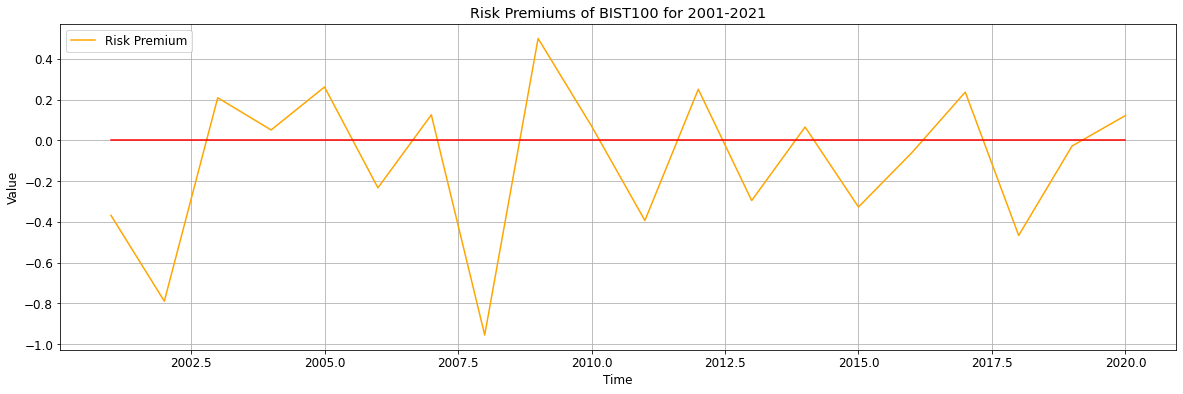

In [ ]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6))

# Specify how our lines should look
ax.plot(df_BIST100_rp['Year_ID'], 
        df_BIST100_rp['Risk_Premium'], 
        color='orange', label='Risk Premium')
ax.plot(df_BIST100_rp['Year_ID'], 
        np.zeros(df_BIST100_rp.shape[0]), 
        color='red')


ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title('Risk Premiums of BIST100 for 2001-2021')
ax.grid(True)
ax.legend(loc='upper left');

In [ ]:
print('Avarage Risk Premium of BIST100 for years 2001-2021 is: ',df_BIST100_rp['Risk_Premium'].mean())

Avarage Risk Premium of BIST100 for years 2001-2021 is:  -0.10146097674664487


### Portfolio Scenario

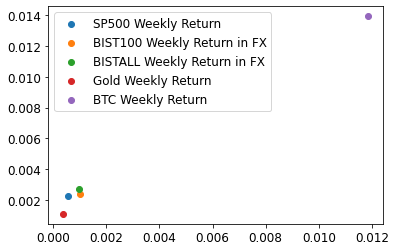

In [ ]:
y = df_master_w[(df_master_w["Year_ID"] >=2015)][['SP500 Weekly Return','BIST100 Weekly Return in FX','BISTALL Weekly Return in FX','Gold Weekly Return',
            'BTC Weekly Return']].mean(axis = 0, skipna = False)
x = df_master_w[(df_master_w["Year_ID"] >=2015)][['SP500 Weekly Return','BIST100 Weekly Return in FX','BISTALL Weekly Return in FX','Gold Weekly Return',
            'BTC Weekly Return']].var(axis = 0, skipna = False)

colors = ["red", "yellow", "blue","orange","black"]
c = ['SP500 Weekly Return','BIST100 Weekly Return in FX','BISTALL Weekly Return in FX','Gold Weekly Return','BTC Weekly Return']

for i in range(0,5):
    plt.scatter(x[i], y[i], label=c[i])
plt.legend()

In [ ]:
df_master_w[(df_master_w["Year_ID"] >=2016) & (df_master_w["Year_ID"] <=2020)][['SP500 Weekly Return','BISTALL Weekly Return in FX','Gold Weekly Return',
            'BTC Weekly Return']].mean(axis = 0, skipna = False)

SP500 Weekly Return            0.002245
BISTALL Weekly Return in FX    0.002925
Gold Weekly Return             0.002137
BTC Weekly Return              0.015902
dtype: float64

In [ ]:
t0=df_master_w[(df_master_w["Year_ID"] >=2021)][['SP500 Weekly Return','BISTALL Weekly Return in FX','Gold Weekly Return',
            'BTC Weekly Return']].shape[0]
#t0=number of weeks in 2021 
t1=df_master_w[(df_master_w["Year_ID"] >=2016) & (df_master_w["Year_ID"] <=2020)][['SP500 Weekly Return','BISTALL Weekly Return in FX','Gold Weekly Return',
            'BTC Weekly Return']].mean(axis = 0, skipna = False).mean()
#t2total mean return
print('By investing 1000$ equally to these 4 assets I expect to have ',(t0*t1+1)*1000, '$')

By investing 1000$ equally to these 4 assets I expect to have  1290.1052318286754 $


In [ ]:
t2=250*int(df_master_w[(df_master_w["Year_ID"] >=2021)][['SP500 Index']].tail(1)['SP500 Index'])/int(df_master_w[(df_master_w["Year_ID"] >=2021)][['SP500 Index']].head(1)['SP500 Index'])+250*int(df_master_w[(df_master_w["Year_ID"] >=2021)][['Gold Price ($/t oz)']].tail(1)['Gold Price ($/t oz)'])/int(df_master_w[(df_master_w["Year_ID"] >=2021)][['Gold Price ($/t oz)']].head(1)['Gold Price ($/t oz)'])+250*int(df_master_w[(df_master_w["Year_ID"] >=2021)][['Bitcoin Price']].tail(1)['Bitcoin Price'])/int(df_master_w[(df_master_w["Year_ID"] >=2021)][['Bitcoin Price']].head(1)['Bitcoin Price'])+250*int(df_master_w[(df_master_w["Year_ID"] >=2021)][['BISTALL Index']].tail(1)['BISTALL Index'])/int(df_master_w[(df_master_w["Year_ID"] >=2021)][['BISTALL Index']].head(1)['BISTALL Index'])

In [ ]:
print('By investing 1000$ equally to these 4 assets I would  have ',t2, '$')

By investing 1000$ equally to these 4 assets I would  have  1271.706754514445 $
